# Fragility Robustness Analysis

This notebook generates:
1. Success Rate vs Fragility Level bar plot
2. Break Rate vs Fragility Level bar plot

In [27]:
# ============================================================
# BLOCK 1: IMPORTS & LOCAL CONFIGURATION
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import shared utilities
from analysis_utils import (
    # Constants
    ENTITY, PROJECT, COLORS,
    TAG_EVAL_PERFORMANCE, TAG_EVAL_FRAGILE,
    METRIC_SUCCESS, METRIC_BREAKS, METRIC_TOTAL,
    # Data functions
    get_best_checkpoint_per_run,
    download_eval_data,
    filter_top_n_runs,
    # Plotting functions
    plot_rate_figure,
    print_data_summary,
)

# ============================================================
# LOCAL CONFIGURATION (specific to this analysis)
# ============================================================

# Method Tags (from unbreakable training condition)
METHOD_TAGS = {
    #unbreakable
    #"Pose(1mm)": "pose_base-case:2026-02-02_13:40",
    #"MATCH(1mm)": "MATCH_base-case:2026-02-04_17:46",
    #"Hybrid-Basic(1mm)": "basic-hybrid_base-case:2026-02-02_13:40",

    #20N
    "Pose(1mm)": "pose_breakable_f20N:2026-02-02_13:41",
    #"Pose(2.5mm)": "",
    "MATCH(1mm)": "MATCH_breakable_f20N:2026-02-02_13:41",
    "Hybrid-Basic(1mm)": "basic-hybrid_breakable_f20N:2026-02-02_13:41",
}

# Fragility Level Mapping: display label -> metric key
FRAGILITY_LEVELS = {
    "5N": "5N",
    "10N": "10N",
    "15N": "15N",
    "20N": "20N",
}

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all
MAX_CHECKPOINT = None  # Set to int to limit checkpoint search

# Plot Configuration
SUCCESS_Y_LIM = (0, 100)
SUCCESS_Y_TICKS = [0, 20, 40, 60, 80, 100]
BREAK_Y_LIM = (0, 50)  # Adjust based on expected break rates
BREAK_Y_TICKS = [0, 10, 20, 30, 40, 50]

# Error type: "ci" for 95% confidence interval, "binary_se" for binary standard error
ERROR_TYPE = "ci"

In [28]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

api = wandb.Api()
best_checkpoints_by_method = {}

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{method_name} ({method_tag}):")
    best_checkpoints_by_method[method_name] = get_best_checkpoint_per_run(
        api, method_tag, max_checkpoint=MAX_CHECKPOINT
    )


Pose(1mm) (pose_breakable_f20N:2026-02-02_13:41):
  Eval_performance_pose_breakable_f(20)_1: best checkpoint at step 1612800 (score: 99)
  Eval_performance_pose_breakable_f(20)_0: best checkpoint at step 1574400 (score: 97)
  Eval_performance_pose_breakable_f(20)_2: best checkpoint at step 1728000 (score: 94)
  Eval_performance_pose_breakable_f(20)_4: best checkpoint at step 2227200 (score: 98)
  Eval_performance_pose_breakable_f(20)_3: best checkpoint at step 1651200 (score: 93)

MATCH(1mm) (MATCH_breakable_f20N:2026-02-02_13:41):
  Eval_performance_MATCH_breakable_f(20)_0: best checkpoint at step 1190400 (score: 100)
  Eval_performance_MATCH_breakable_f(20)_1: best checkpoint at step 2073600 (score: 99)
  Eval_performance_MATCH_breakable_f(20)_2: best checkpoint at step 1305600 (score: 100)
  Eval_performance_MATCH_breakable_f(20)_4: best checkpoint at step 1152000 (score: 98)
  Eval_performance_MATCH_breakable_f(20)_3: best checkpoint at step 1996800 (score: 100)

Hybrid-Basic(1mm)

In [29]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

# Download fragility evaluation data
fragility_data = {}
for method_name, method_tag in METHOD_TAGS.items():
    print(f"\nDownloading fragility data for {method_name}...")
    fragility_data[method_name] = download_eval_data(
        api=api,
        method_tag=method_tag,
        best_checkpoints=best_checkpoints_by_method[method_name],
        level_mapping=FRAGILITY_LEVELS,
        prefix_template="Fragile_Eval({level})_Core",
        level_col_name="fragility_level",
        eval_tag=TAG_EVAL_FRAGILE,
    )

# Print summary
print_data_summary(
    data=fragility_data,
    level_labels=list(FRAGILITY_LEVELS.keys()),
    level_col="fragility_level",
    metric="success",
    title="FRAGILITY DATA SUMMARY (Success Rate)",
)




FRAGILITY DATA SUMMARY (Success Rate)

Pose(1mm):
  5N: 9.8%
  10N: 60.3%
  15N: 91.8%
  20N: 94.8%

MATCH(1mm):
  5N: 0.0%
  10N: 31.0%
  15N: 82.5%
  20N: 97.4%

Hybrid-Basic(1mm):
  5N: 1.6%
  10N: 56.2%
  15N: 92.5%
  20N: 97.1%


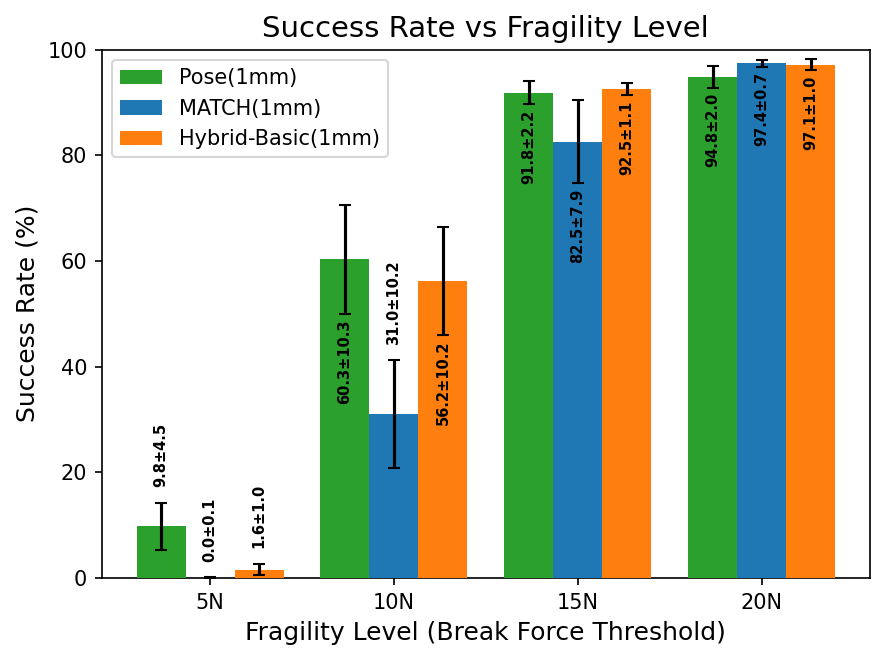

In [30]:
# ============================================================
# BLOCK 4: SUCCESS RATE VS FRAGILITY LEVEL
# ============================================================

fig, ax = plot_rate_figure(
    data=fragility_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(FRAGILITY_LEVELS.keys()),
    level_col="fragility_level",
    metric="success",
    title="Success Rate vs Fragility Level",
    x_label="Fragility Level (Break Force Threshold)",
    y_label="Success Rate (%)",
    y_lim=SUCCESS_Y_LIM,
    y_ticks=SUCCESS_Y_TICKS,
    error_type=ERROR_TYPE,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.show()

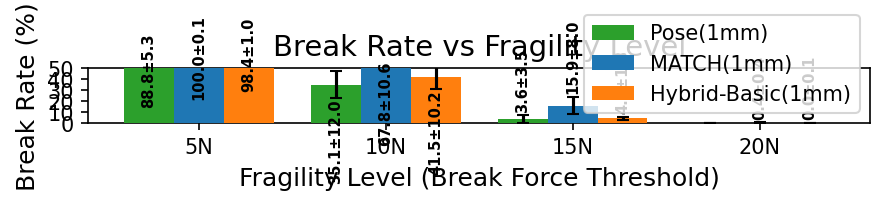

In [31]:
# ============================================================
# BLOCK 5: BREAK RATE VS FRAGILITY LEVEL
# ============================================================

fig, ax = plot_rate_figure(
    data=fragility_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(FRAGILITY_LEVELS.keys()),
    level_col="fragility_level",
    metric="breaks",
    title="Break Rate vs Fragility Level",
    x_label="Fragility Level (Break Force Threshold)",
    y_label="Break Rate (%)",
    y_lim=BREAK_Y_LIM,
    y_ticks=BREAK_Y_TICKS,
    error_type=ERROR_TYPE,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.show()